In [1]:
using Colors, DataFrames, Images, ImageTransformations, Interpolations, Memoize, Plots, Polynomials, TestImages, Statistics

function lagrange(xs, ys, x)
    result = 0
    for i = xs
        t = ys[i]
        for j = xs
            if i != j
                t *= (x - xs[j]) / (xs[i] - xs[j])
            end
        end
        result += t
    end
    return result
end     

┌ Info: Recompiling stale cache file /home/piotr/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184


lagrange (generic function with 1 method)

  0.106319 seconds (155.68 k allocations: 7.244 MiB, 13.11% gc time)


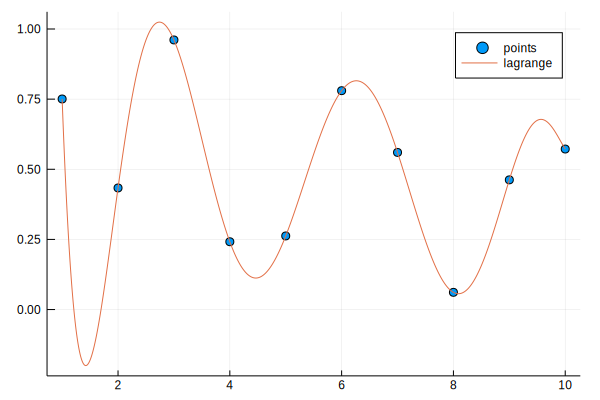

In [11]:
xs = 1:10
ys = rand(size(xs, 1))

l_xs = 1:0.01:10
@time l_ys = [lagrange(xs, ys, x) for x in l_xs]

scatter(xs, ys, label="points")
plot!(l_xs, l_ys, label="lagrange")

In [3]:
# @memoize function div_diff(ys, xa, xb)
#     if xa == xb
#         return ys[xa]
#     end
    
#     return (div_diff(ys, xa + 1, xb) - div_diff(ys, xa, xb - 1)) / (xb - xa)
# end

# function div_table(ys)
#     dt = zeros(size(ys, 1))
#     for i = 1:size(ys, 1)
#         dt[i] = div_diff(ys, 1, i)
#     end
#     return dt
# end

function div_table(xs, ys)
    n = size(xs, 1)
    T = zeros(n, n)
    
    for i = 1:n
        T[i, 1] = ys[i]
    end
    
    for j = 2:n
        for i = j:n
            T[i, j] = (T[i, j - 1] - T[i - 1, j - 1]) / (xs[i] - xs[1 + i - j])
        end
    end
    
    dt = zeros(n)
    for i = 1:n
        dt[i] = T[i, i]
    end
    
    return dt
end

function newton(dt, xs, ys, x)
    result = 0
    for i = 1:size(xs, 1)
        a = dt[i]
        t = 1
        if i == 1
            result += a
        else
            for j = 1:(i - 1)
                t *= x - xs[j]
            end
            result += a * t
        end
    end
    return result
end

newton (generic function with 1 method)

  0.000014 seconds (6 allocations: 1.188 KiB)
  0.084862 seconds (155.69 k allocations: 7.254 MiB)


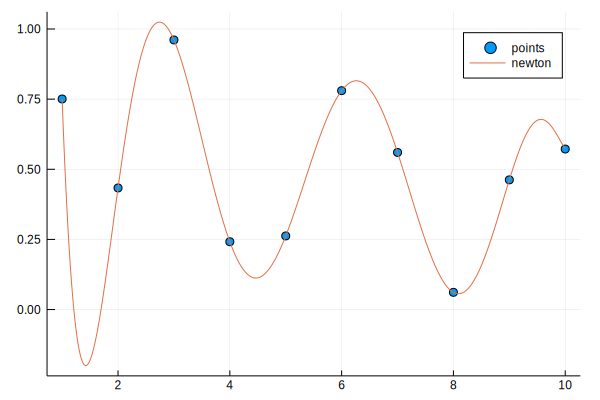

In [14]:
n_xs = 1:0.01:10
@time dt = div_table(xs, ys)
@time n_ys = [newton(dt, xs, ys, x) for x in n_xs]

scatter(xs, ys, label="points")
plot!(n_xs, n_ys, label="newton")

  1.638909 seconds (4.61 M allocations: 220.733 MiB, 14.06% gc time)


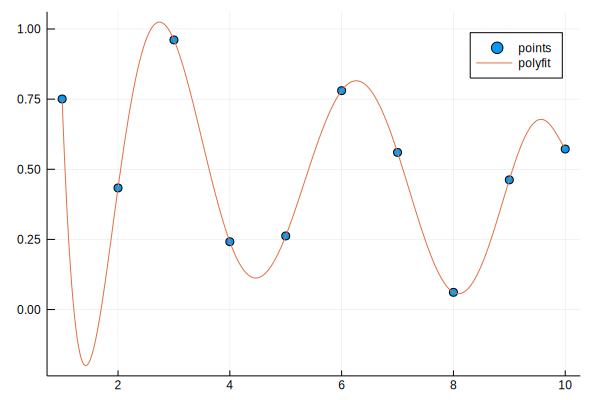

In [15]:
p_xs = 1:0.01:10
@time p_ys = [polyfit(xs, ys)(x) for x in p_xs]

scatter(xs, ys, label="points")
plot!(p_xs, p_ys, label="polyfit")

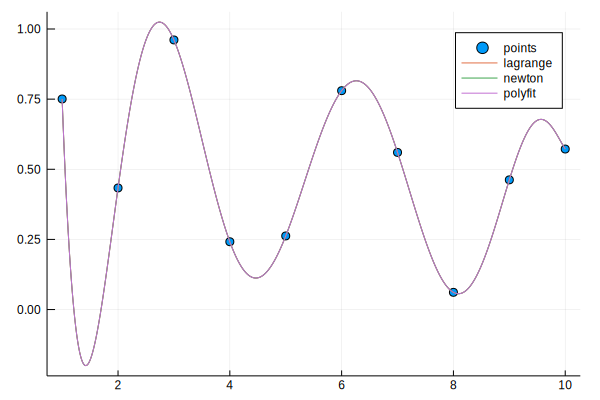

In [16]:
scatter(xs, ys, label="points")
plot!(l_xs, l_ys, label="lagrange")
plot!(n_xs, n_ys, label="newton")
plot!(p_xs, p_ys, label="polyfit")

In [56]:
df1 = DataFrame(size=Int[], lagrange=Float64[], newton=Float64[], polyfit=Float64[])

for s = 10:5:200
    t_xs = 1:s
    t_ys = rand(size(t_xs, 1))
    n1 = @elapsed t_dt = div_table(t_xs, t_ys)
    p1 = @elapsed t_fit = polyfit(t_xs, t_ys)
    for i = 1:11
        l = @elapsed [lagrange(t_xs, t_ys, x) for x in t_xs]
        n2 = @elapsed [newton(t_dt, t_xs, t_ys, x) for x in t_xs] 
        p2 = @elapsed [t_fit(x) for x in t_xs]
        
        if i > 1
            push!(df1, [s, l, n1 + n2, p1 + p2])
        end
    end
end

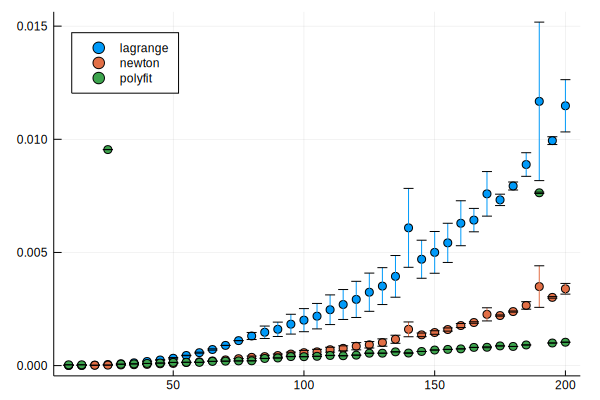

In [57]:
df2 = by(df1, :size,
    df->DataFrame(
        lagrange_mean=mean(df[:lagrange]), lagrange_std=std(df[:lagrange]),
        newton_mean=mean(df[:newton]), newton_std=std(df[:newton]),
        polyfit_mean=mean(df[:polyfit]), polyfit_std=std(df[:polyfit])
    )
)

scatter(df2[:size],
    [df2[:lagrange_mean], df2[:newton_mean], df2[:polyfit_mean]],
    yerr=[df2[:lagrange_std] df2[:newton_std] df2[:polyfit_std]],
    label=["lagrange" "newton" "polyfit"], legend=:topleft
)

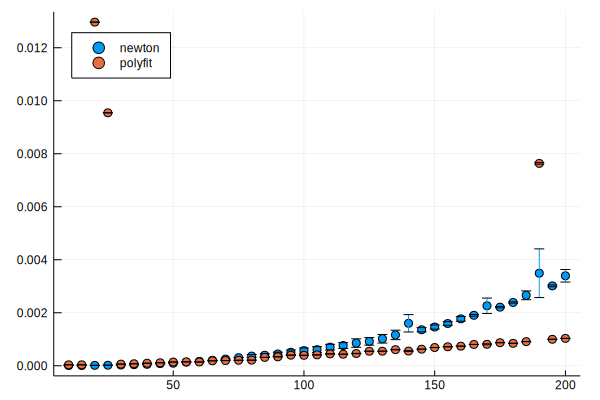

In [58]:
scatter(df2[:size],
    [df2[:newton_mean], df2[:polyfit_mean]],
    yerr=[df2[:newton_std] df2[:polyfit_std]],
    label=["newton" "polyfit"], legend=:topleft
)

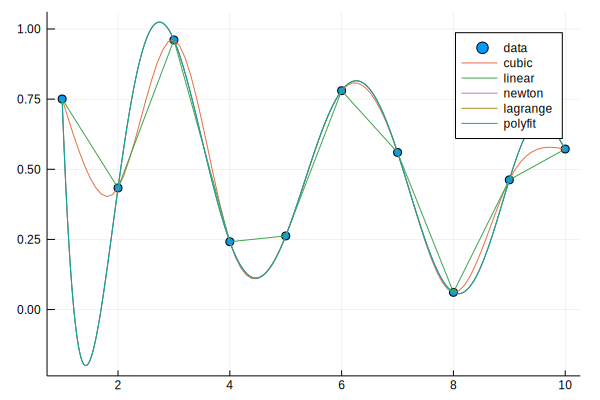

In [20]:
cub_xs = 1:0.1:10
cub = CubicSplineInterpolation(xs, ys)
cub_ys = [cub(x) for x in cub_xs]

lin_xs = 1:0.1:10
lin = LinearInterpolation(xs, ys)
lin_ys = [lin(x) for x in lin_xs]

scatter(xs, ys, label="data")
plot!(cub_xs, cub_ys, label="cubic")
plot!(lin_xs, lin_ys, label="linear")
plot!(n_xs, n_ys, label="newton")
plot!(l_xs, l_ys, label="lagrange")
plot!(p_xs, p_ys, label="polyfit")

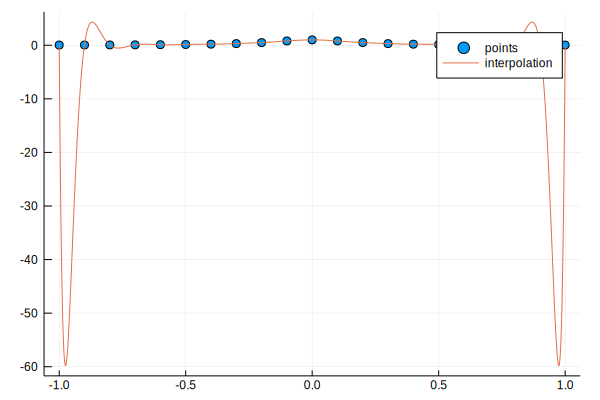

In [21]:
function runge(x)
    return 1 / (25 * x ^ 2 + 1)
end

r_xs = -1:0.1:1
r_ys = [runge(x) for x in r_xs]
scatter(r_xs, r_ys, label="points")

rp_xs = -1:0.001:1
rp_ys = [polyfit(r_xs, r_ys)(x) for x in rp_xs]
plot!(rp_xs, rp_ys, label="interpolation")

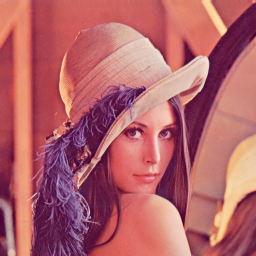

In [64]:
img = testimage("lena_color_256")

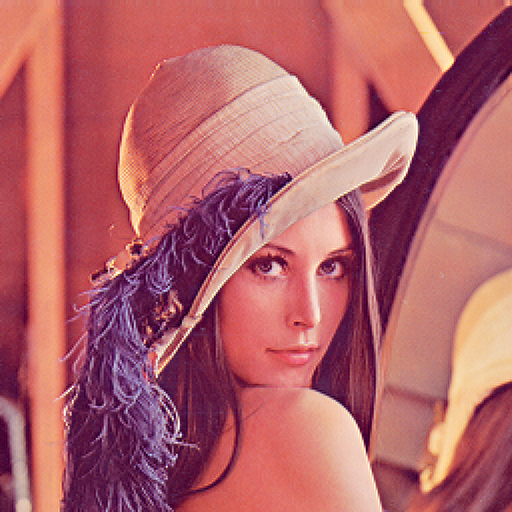

In [77]:
function scale_bilinear(img, ratio)
    img_y = size(img, 1)
    img_x = size(img, 2)
    
    new_h = floor(Int, img_y * ratio)
    new_w = floor(Int, img_x * ratio)
    
    new = zeros(new_h, new_w)
    
    for h = 1:new_h
        for w = 1:new_w
            y = floor(Int, (h - 1) / ratio) + 1
            x = floor(Int, (w - 1) / ratio) + 1
                        
            y_diff = h / ratio - y
            x_diff = w / ratio - x
            
            l_x = min(x, img_x - 1)
            l_y = min(y, img_y - 1)
            
            a = img[y, x]         
            b = img[y, l_x + 1]
            c = img[l_y + 1, x]
            d = img[l_y + 1, l_x + 1]
    
            new[h, w] = (
                a * (1 - x_diff) * (1 - y_diff)
                + b * x_diff * (1 - y_diff)
                + c * y_diff * (1 - x_diff)
                + d * x_diff * y_diff
            ) 
        end
    end
    return new
end

function scale_image(img, ratio)
    channels = channelview(img)
    R = channels[1, :, :]
    G = channels[2, :, :]
    B = channels[3, :, :]

    Rc = scale_bilinear(R, ratio)
    Gc = scale_bilinear(G, ratio)
    Bc = scale_bilinear(B, ratio)

    return colorview(RGB, Rc, Gc, Bc)
end

scale_image(img, 2.0)

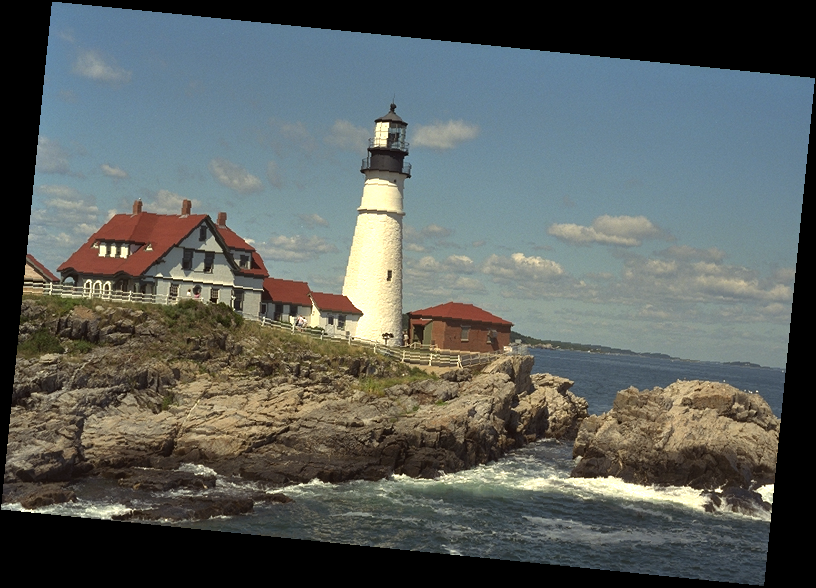

In [112]:
img2 = testimage("lighthouse")

imrotate(img2, 0.1, Constant())

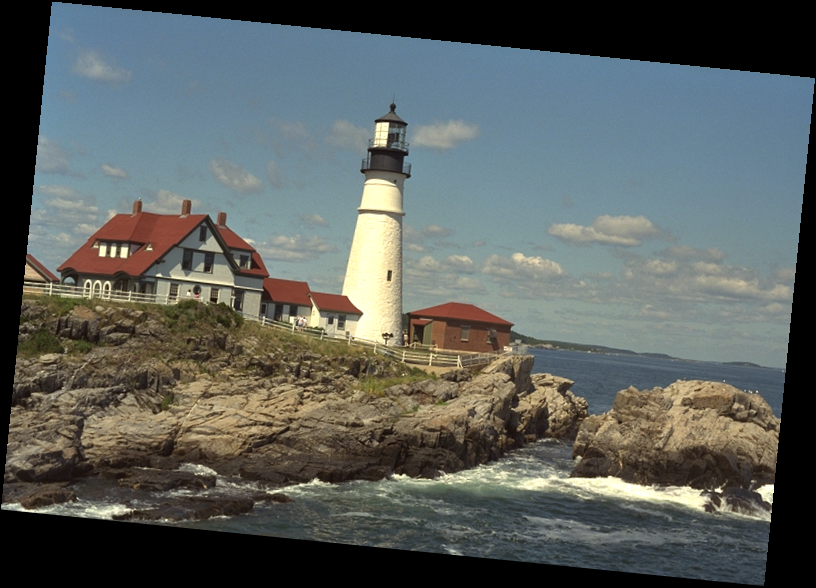

In [113]:
imrotate(img2, 0.1, Linear())